# DSCI 100: Final Project Report, Group 2

## Introduction

The PLAI group at UBC, using a MineCraft server, collected data about how people play video games through automated tracking and user-reported information. Two datasets were provided: `sessions.csv` and `players.csv`.

The goal of this analysis is to answer the question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? 

To address this broader question, this analysis will use the data in the `players.csv` dataset to answer a more specific question: **Can age and the total hours played by a player predict whether they subscribe to a game-related newsletter?**

The `players.csv` dataset contains the data necessary to answer this specific question, formatted already into a table such that the explanatory variables, `played_hours` and `Age`, are in their own columns and can be analyzed to see if they can predict the response variable, `subscribe` (whether or not the player subscribes to the game-related newsletter). Each player is one observation in this dataset, so we can compare these variables for each player and see if the explanatory variables are good predictors.

**For flow, the code to load and calculate summary statistics for each dataset is written in the Methods section. This section is only for descriptions of data derived from the code output from Methods.**

#### `players.csv` Overview

The `players.csv` dataset provides information about each player. There are 196 observations and the dataset contains 7 variables:

| Variable | Data type | Meaning |
| :------- | :------- | :------- |
| experience | Character | Experience level of the player |
| subscribe | Logical | Whether the player subscribed to a game-related newsletter |
| hashedEmail | Character | Anonymized identifier for each player's email |
| played_hours | Double (Numeric) | Total time spent playing for each player in hours |
| name | Character | Player name |
| gender | Character | Player gender |
| Age | Double (Numeric) | Player age in years |

Potential problems in this dataset are:
- The values in the `subscribe` variable column are of the logical data type, and are not very descriptive of what the data means. They could be changed to factor type and renamed to describe the status of a player's subscription.
- There are missing (NA) values for some observations in the `Age` variable; these need to be dealt with prior to gathering summary statistics.
- It's not clear how the data was collected, such as how player experience was gauged (self-reported? Other testing metrics?).
- `name` is not necessary, especially with `hashedEmail` as an identifier.

#### Summary Statistics for `players.csv` Dataset

The mean age of each player is 21.14 years, with a range from 9 to 58 years. The mean hours played per player is 5.90 hours, with a range of 0 to 223.1 hours. 

| Variable | Mean | Min | Max |
| :------- | :------- | :------- | :------- |
| Age (years) | 21.14 | 9 | 58 |
| Hours played per player | 5.90 | 0 | 223.1 |

## Methods & Results

#### Load Libraries and Data

The first step is to load libraries and read in the dataset so that we can observe the dataset, obtain summary statistics, and describe it. **Descriptions and summary statistics obtained from this analysis are reported in the Introduction.**

In [2]:
#Loading libraries

library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
#Reading in data from the players dataset

players_url <- "https://drive.google.com/uc?export=download&id=1wPawgc5uTyx2Btw3NTQR8VPvyRDrLwqT"

players_data <- read_csv(players_url)
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


#### Tidying Data

The data now must be wrangled and tidied so that it is ready for analysis. To do this, we remove the rows with NA and convert the columns into the appropriate data type. In the `subscribe` column, `FALSE` and `TRUE` values were changed to `Unsubscribed` and `Subscribed` to make this more descriptive.

In [22]:
#Tidying data: removing rows with NA, converting to correct data types, and changing to descriptive names

players_data <- players_data |>
                filter(!is.na(Age), !is.na(played_hours), !is.na(subscribe)) |>
                mutate(subscribe = as.factor(subscribe),
                       subscribe = recode(subscribe, "FALSE" = "Unsubscribed", "TRUE" = "Subscribed"))
players_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Subscribed,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,Unsubscribed,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,Unsubscribed,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,Unsubscribed,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,Unsubscribed,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


#### Summary Statistics Calculations

The next step is to perform a summary of the data for exploratory analysis.

In [23]:
#Players dataset: Mean for each quantitative variable
mean_players_data <- players_data |>
    select(played_hours, Age) |>
    map_df(mean)
mean_players_data

#Players dataset: Min and max for each quantitative variable
max_min_players <- players_data |> 
    summarize(min_played_hours = min(played_hours),
              max_played_hours = max(played_hours),
              min_age = min(Age),
              max_age = max(Age))
max_min_players

played_hours,Age
<dbl>,<dbl>
5.904639,21.13918


min_played_hours,max_played_hours,min_age,max_age
<dbl>,<dbl>,<dbl>,<dbl>
0,223.1,9,58


The mean age of each player is 21.14 years, with a range from 9 to 58 years. The mean hours played per player is 5.90 hours, with a range of 0 to 223.1 hours. This is also reported in a table in the Introduction.

#### Exploratory Visualizations

As part of exploratory analysis, we will create a visualization to explore potential relationships between subscription status of players based on their age and total hours played.

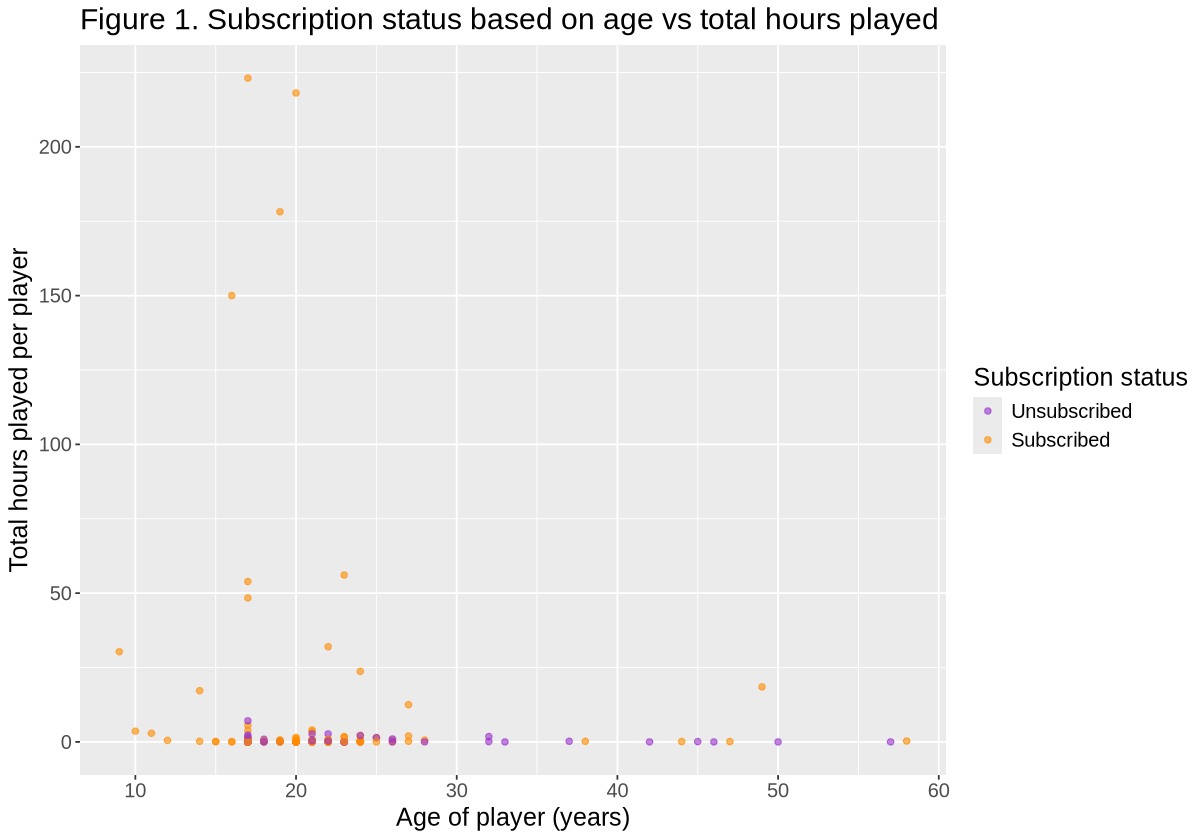

In [24]:
options(repr.plot.width = 10)

age_vs_played_hours <- players_data |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age of player (years)",
         y = "Total hours played per player",
         title = "Figure 1. Subscription status based on age vs total hours played",
         color = "Subscription status") +
    scale_color_manual(values = c("Unsubscribed" = "darkorchid", "Subscribed" = "darkorange")) +
    theme(text = element_text(size = 15))
age_vs_played_hours

This scatterplot indicates that there is no relationship between age and total hours played. Also, most users have not played more than 50 hours, but of the ones that do, all have subscribed. Individuals that have played a lot of hours tend to be subscribed and also younger -- no one over the age of 30 has played more than 25 hours. These, especially hours played, are therefore potential predictors for subscription status.

#### Data Analysis

(TO BE WORKED ON)

#### Visualization of Analysis

(TO BE WORKED ON)

## Discussion

TO BE WORKED ON. The following must be added:

- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to

## References

- You may include references if necessary, as long as they all have a consistent citation style.